In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [ ]:
train_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/test"

In [ ]:
import os
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [ ]:

corrupted_images = []  # List to store corrupted image paths

# Loop through each class folder and check for corrupted images
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a valid directory
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

# Print results
if corrupted_images:
    print("\nCorrupted Images Found:")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")



No corrupted images found.


In [ ]:
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)

print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)



Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


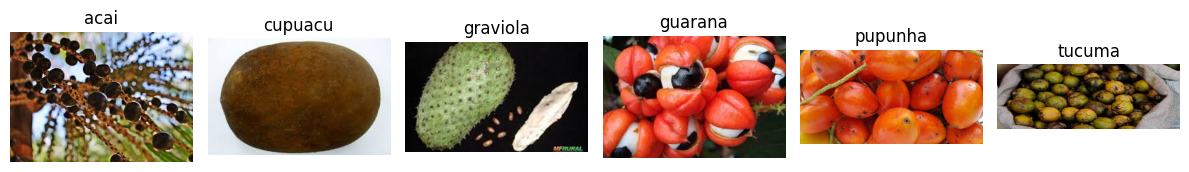

In [ ]:


selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

num_classes = len(selected_images)
fig, axes = plt.subplots(1,num_classes, figsize=(12,6))

if num_classes == 1:
    axes = [axes]

for ax, img_path, label in zip(axes, selected_images, selected_labels):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 64


# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Verify class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")




Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:

from tensorflow.keras.layers import LeakyReLU

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    for filters in [32, 64, 128, 256]:
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.15)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = make_model(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 28, 28, 256)         │           1,0

 Total params: 491,334 (1.87 MB)

 Trainable params: 489,606 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('best_model_task1.h5', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train
history = model.fit(
    train_ds,
    epochs=250,
    batch_size = batch_size,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1915 - loss: 2.5288  

2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 14s/step - accuracy: 0.1980 - loss: 2.5212 - val_accuracy: 0.1667 - val_loss: 1.7885
Epoch 2/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4142 - loss: 1.7419  

2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.4169 - loss: 1.7352 - val_accuracy: 0.2000 - val_loss: 1.7833
Epoch 3/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4009 - loss: 1.5987  

2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.4043 - loss: 1.5972 - val_accuracy: 0.2667 - val_loss: 1.7754
Epoch 4/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.5535 - loss: 1.2691 - val_accuracy: 0.2333 - val_loss: 1.7682
Epoch 5/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 11s/step - accuracy: 0.4265 - loss: 1.3605 - val_accuracy: 0.2333 - val_loss: 1.7626
Epoch 6/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 11s/step - accuracy: 0.4970 - loss: 1.3705 - val_accuracy: 0.2000 - val_loss: 1.7627
Epoch 7/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.4822 - loss: 1.2946 - val_accuracy: 0.2333 - val_loss: 1.7617
Epoch 8/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 62s 13s/step - accuracy: 0.5044 - loss: 1.1403 - val_accuracy: 0.2333 - val_loss: 1.7609
Epoch 9/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.6306 - loss: 1.1161 - val_accuracy: 0.2667 - val_loss: 1.7561
Epoch 10/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.5883 - loss: 1.0294 - val_accuracy: 0.2667 - val_loss: 1.7560
Epoch 11

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2667 - loss: 1.7560
Test accuracy: 0.2667
Test loss: 1.7560


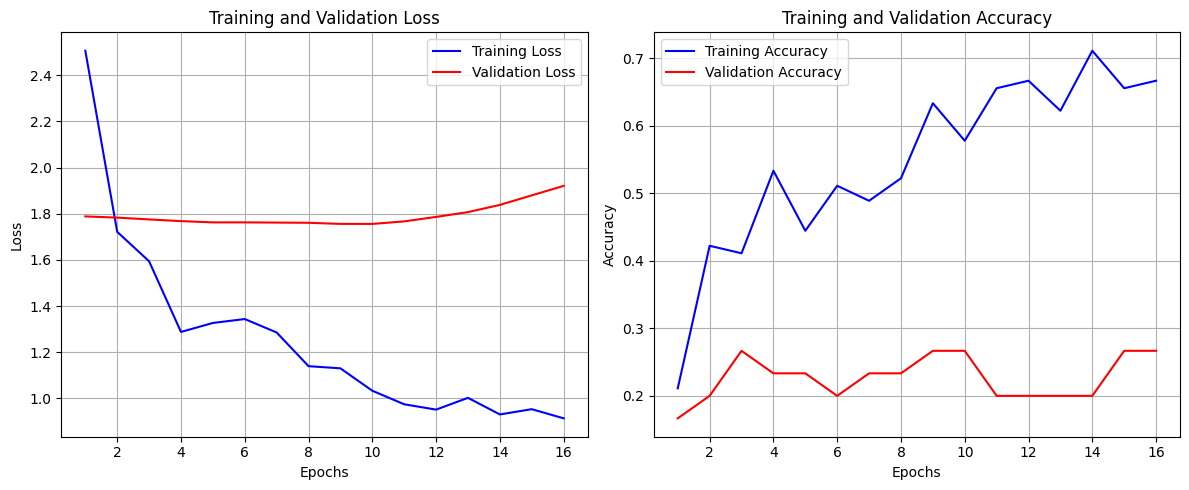

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
model.save('Bhupen_Week6_task1.h5')
print("Model saved as 'Bhupen_Week6_task1.h5'")

Model saved as 'Bhupen_Week6_task1.h5'


In [ ]:
loaded_model = tf.keras.models.load_model('Bhupen_Week6_task1.h5')
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")
print(f"Loaded model test loss: {loaded_test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2667 - loss: 1.7560
Loaded model test accuracy: 0.2667
Loaded model test loss: 1.7560


In [ ]:
loaded_model = keras.models.load_model('Bhupen_Week6_task1.h5')
print("Model loaded for predictions")

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)  # Shape: (30, 128, 128, 3)
test_labels_onehot = np.concatenate(all_labels, axis=0)  # Shape: (30, 6)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)


print(f"Class names: {class_names}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Model loaded for predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       0.00      0.00      0.00         5
     cupuacu       0.19      1.00      0.31         5
    graviola       1.00      0.60      0.75         5
     guarana       0.00      0.00      0.00         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.00      0.00      0.00         5

    accuracy                           0.27        30
   macro avg       0.20      0.27      0.18        30
weighted avg       0.20      0.27      0.18        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_vgg = keras.Model(inputs=base_model.input, outputs=outputs)

In [ ]:
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history_vgg = model_vgg.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    callbacks=[ModelCheckpoint('best_model_task2.h5', monitor='val_accuracy', save_best_only=True),
               EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.0490 - loss: 6.9166 

2/2 ━━━━━━━━━━━━━━━━━━━━ 83s 37s/step - accuracy: 0.0549 - loss: 6.9404 - val_accuracy: 0.3667 - val_loss: 8.6190
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.3641 - loss: 6.1276 

2/2 ━━━━━━━━━━━━━━━━━━━━ 111s 57s/step - accuracy: 0.3760 - loss: 6.0446 - val_accuracy: 0.4667 - val_loss: 4.1345
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.7049 - loss: 2.2501  

2/2 ━━━━━━━━━━━━━━━━━━━━ 117s 35s/step - accuracy: 0.7106 - loss: 2.1894 - val_accuracy: 0.5333 - val_loss: 4.9288
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 133s 36s/step - accuracy: 0.7916 - loss: 1.1311 - val_accuracy: 0.4667 - val_loss: 4.6875
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8363 - loss: 0.4749 

2/2 ━━━━━━━━━━━━━━━━━━━━ 87s 38s/step - accuracy: 0.8390 - loss: 0.4698 - val_accuracy: 0.5667 - val_loss: 2.8260
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9165 - loss: 0.2517 

2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 34s/step - accuracy: 0.9147 - loss: 0.2711 - val_accuracy: 0.6667 - val_loss: 1.9383
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9833 - loss: 0.1366 

2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 34s/step - accuracy: 0.9778 - loss: 0.1728 - val_accuracy: 0.8000 - val_loss: 1.7401
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 36s/step - accuracy: 0.9495 - loss: 0.1862 - val_accuracy: 0.8000 - val_loss: 1.5924
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 103s 57s/step - accuracy: 0.9874 - loss: 0.0523 - val_accuracy: 0.8000 - val_loss: 1.5404
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 36s/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.7667 - val_loss: 1.6141
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 36s/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.7667 - val_loss: 1.6874
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 84s 36s/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.7667 - val_loss: 1.7398
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 36s/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.7667 - val_loss: 1.7858
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 34s/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.7667 - val_loss: 1.8222
Epoch

2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 37s/step - accuracy: 1.0000 - loss: 6.7525e-04 - val_accuracy: 0.8333 - val_loss: 1.8618
Epoch 19/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 83s 36s/step - accuracy: 1.0000 - loss: 4.3780e-04 - val_accuracy: 0.8333 - val_loss: 1.8664
Epoch 20/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 73s 35s/step - accuracy: 1.0000 - loss: 3.6477e-04 - val_accuracy: 0.8333 - val_loss: 1.8691
Epoch 21/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 36s/step - accuracy: 1.0000 - loss: 3.1130e-04 - val_accuracy: 0.8333 - val_loss: 1.8700
Epoch 22/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 84s 36s/step - accuracy: 1.0000 - loss: 2.2177e-04 - val_accuracy: 0.8333 - val_loss: 1.8692
Epoch 23/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 84s 36s/step - accuracy: 1.0000 - loss: 2.5967e-04 - val_accuracy: 0.8333 - val_loss: 1.8681
Epoch 24/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 36s/step - accuracy: 1.0000 - loss: 2.2777e-04 - val_accuracy: 0.8333 - val_loss: 1.8664


In [ ]:
# Evaluate
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(test_ds)
print(f"Test accuracy for VGG16: {test_acc_vgg:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.8000 - loss: 1.5404
Test accuracy for VGG16: 0.8000


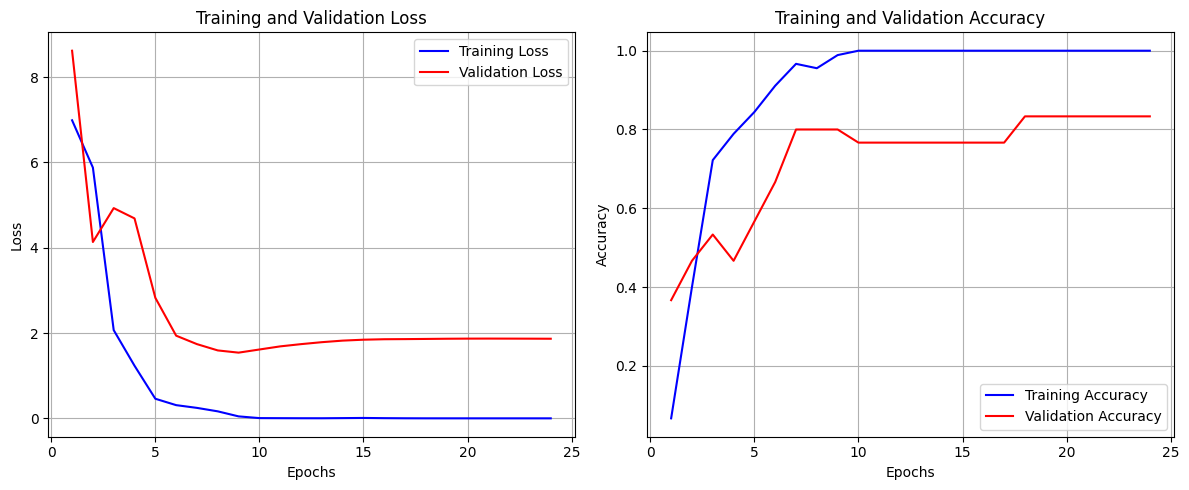

In [ ]:
history_dict = history_vgg.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:

predictions_vgg = model_vgg.predict(test_ds)
y_pred_vgg = np.argmax(predictions_vgg, axis=1)

# Classification Report
print("Classification Report for Task 2 (VGG16):")
print(classification_report(true_labels, y_pred_vgg, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
Classification Report for Task 2 (VGG16):
              precision    recall  f1-score   support

        acai       0.80      0.80      0.80         5
     cupuacu       1.00      0.80      0.89         5
    graviola       0.71      1.00      0.83         5
     guarana       1.00      0.80      0.89         5
     pupunha       0.67      0.80      0.73         5
      tucuma       0.75      0.60      0.67         5

    accuracy                           0.80        30
   macro avg       0.82      0.80      0.80        30
weighted avg       0.82      0.80      0.80        30



In [ ]:
model.save('Bhupen_Week6_task2.h5')
print("Model saved as 'Bhupen_Week6_task2.h5'")

Model saved as 'Bhupen_Week6_task2.h5'
